In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
import itertools
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [2]:
df=pd.read_csv('product c.csv', parse_dates=['Month-Year'])


In [3]:
sales_c= df.drop(['Product Name','Product Category','Month','Year','Month No.'],axis=1)

In [4]:
sales_c = sales_c.rename(columns={'Month-Year': 'ds',
                        'Sales': 'y'})

sales_c.head(5)

,ds,y,Market Size,Marketing Expense
0,2019-01-01,496334,1002744,1578266
1,2019-02-01,306455,619142,974480
2,2019-03-01,476270,962208,1514466
3,2019-04-01,628463,1269687,1998416
4,2019-05-01,366750,740950,1166209


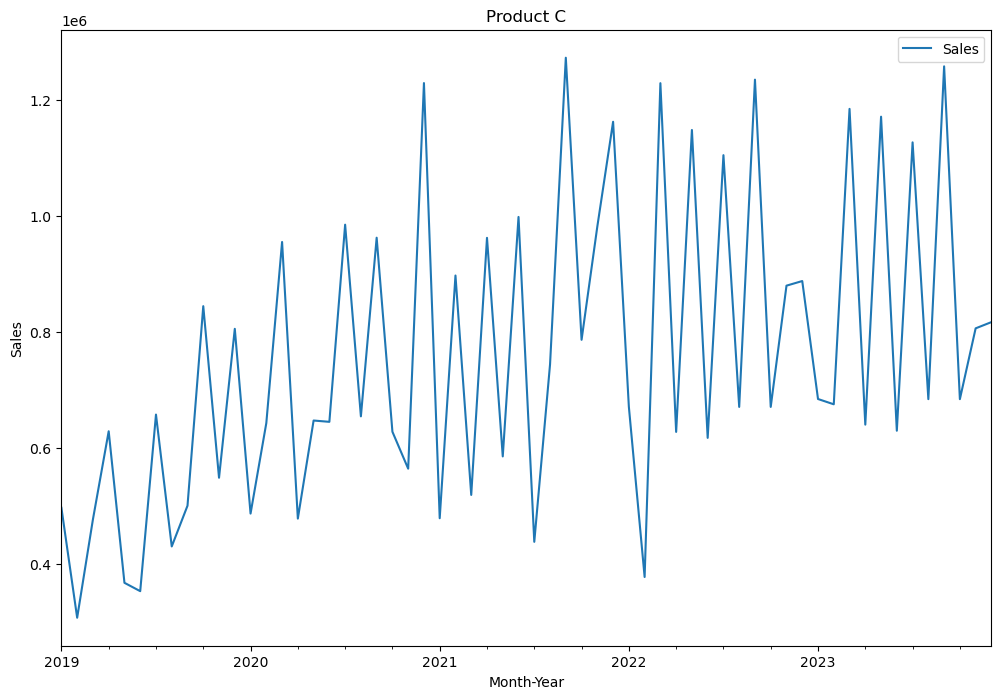

In [5]:
ax = sales_c.set_index('ds')['y'].plot(figsize=(12, 8))
ax.set_ylabel('Sales')
ax.set_xlabel('Month-Year')
plt.title('Product C')
plt.legend(['Sales'])
plt.show()

In [6]:
train= sales_c[:57]
test=sales_c[57:]

In [7]:
changepoint_prior_scale_range = [0.001, 0.01, 0.1,0.2, 0.3, 0.5]
seasonality_prior_scale_range = [0.01, 0.1, 1.0, 3.0, 5.0, 10.0]
seasonality_mode_range = ['additive', 'multiplicative']

param_grid = {  
    'changepoint_prior_scale': changepoint_prior_scale_range,
    'seasonality_prior_scale': seasonality_prior_scale_range,
    'seasonality_mode' : seasonality_mode_range
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params)
    m.add_regressor('Market Size')
    m.add_regressor('Marketing Expense')
    m.fit(train)
    df_cv = cross_validation(m, initial='730 days', period='90 days', horizon = '90 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

10:44:19 - cmdstanpy - INFO - Chain [1] start processing
10:44:19 - cmdstanpy - INFO - Chain [1] done processing
10:44:36 - cmdstanpy - INFO - Chain [1] start processing
10:44:36 - cmdstanpy - INFO - Chain [1] done processing
10:44:51 - cmdstanpy - INFO - Chain [1] start processing
10:44:51 - cmdstanpy - INFO - Chain [1] done processing
10:44:57 - cmdstanpy - INFO - Chain [1] start processing
10:44:57 - cmdstanpy - INFO - Chain [1] done processing
10:45:18 - cmdstanpy - INFO - Chain [1] start processing
10:45:33 - cmdstanpy - INFO - Chain [1] done processing
10:45:38 - cmdstanpy - INFO - Chain [1] start processing
10:45:39 - cmdstanpy - INFO - Chain [1] done processing
10:45:46 - cmdstanpy - INFO - Chain [1] start processing
10:45:47 - cmdstanpy - INFO - Chain [1] done processing
10:45:52 - cmdstanpy - INFO - Chain [1] start processing
10:45:53 - cmdstanpy - INFO - Chain [1] done processing
10:45:58 - cmdstanpy - INFO - Chain [1] start processing
10:45:58 - cmdstanpy - INFO - Chain [1]

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
..                      ...                      ...              ...   
67                    0.500                     3.00   multiplicative   
68                    0.500                     5.00         additive   
69                    0.500                     5.00   multiplicative   
70                    0.500                    10.00         additive   
71                    0.500                    10.00   multiplicative   

             rmse  
0   117956.431046  
1   111296.076537  
2   116098.636423  
3   116700.540519  
4   119042.885305  
.. 

In [8]:
tuning_results.sort_values('rmse',ascending=True)

,changepoint_prior_scale,seasonality_prior_scale,seasonality_mode,rmse
36,0.20,0.01,additive,110480.581698
60,0.50,0.01,additive,110538.962706
24,0.10,0.01,additive,110540.839842
48,0.30,0.01,additive,110659.012011
12,0.01,0.01,additive,111237.138838
...,...,...,...,...
68,0.50,5.00,additive,128355.594716
66,0.50,3.00,additive,128634.923935
42,0.20,3.00,additive,131741.931482
54,0.30,3.00,additive,137979.081467


In [9]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive'}


In [10]:
# Create a Prophet model
#model = Prophet(changepoint_prior_scale=0.0100, seasonality_prior_scale=4.006, interval_width=0.95)
model = Prophet(changepoint_prior_scale=0.2, seasonality_prior_scale=0.01, seasonality_mode= 'additive', interval_width=0.95)
model.add_regressor('Market Size')
model.add_regressor('Marketing Expense')

In [11]:
model.fit(train)

11:06:43 - cmdstanpy - INFO - Chain [1] start processing
11:06:44 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
len(test)

3

In [13]:
# Create a DataFrame for future dates (including 2023)
future_dates = model.make_future_dataframe(periods=len(test), freq='MS')  # 12 months in 2023

In [14]:
future_dates['Market Size'] = sales_c['Market Size']
future_dates['Marketing Expense'] = sales_c['Marketing Expense']

In [15]:
future_dates

,ds,Market Size,Marketing Expense
0,2019-01-01,1002744,1578266
1,2019-02-01,619142,974480
2,2019-03-01,962208,1514466
3,2019-04-01,1269687,1998416
4,2019-05-01,740950,1166209
5,2019-06-01,711811,1120336
6,2019-07-01,1327952,2090113
7,2019-08-01,867822,1365910
8,2019-09-01,1009971,1589625
9,2019-10-01,1107516,1743167


In [16]:
# Make predictions for the future
forecast = model.predict(future_dates)

In [17]:
forecasted_df=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

In [18]:
forecasted_df

,ds,yhat,yhat_lower,yhat_upper
57,2023-10-01,829264.592358,602336.876562,1.070451e+06
58,2023-11-01,768061.319570,543154.591572,9.978467e+05
59,2023-12-01,835252.093798,593735.312124,1.071576e+06


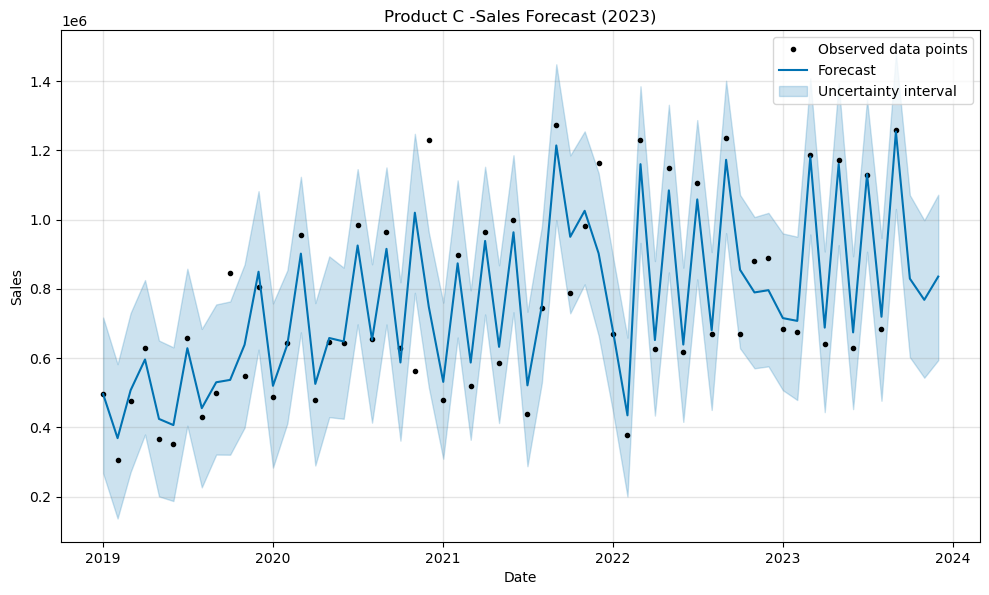

In [19]:
fig = model.plot(forecast, include_legend=True, uncertainty=True)
plt.title('Product C -Sales Forecast (2023)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

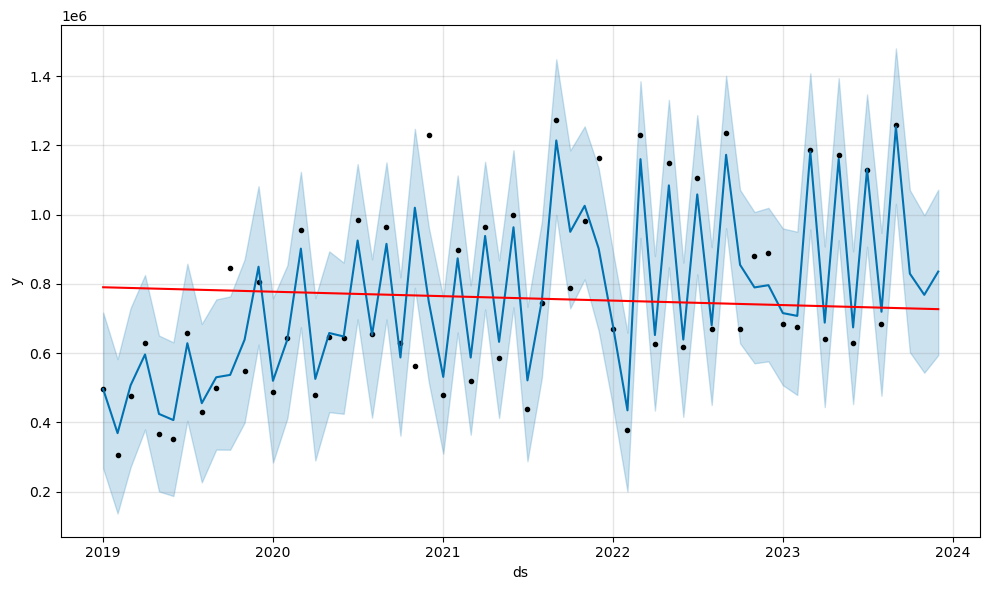

In [20]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

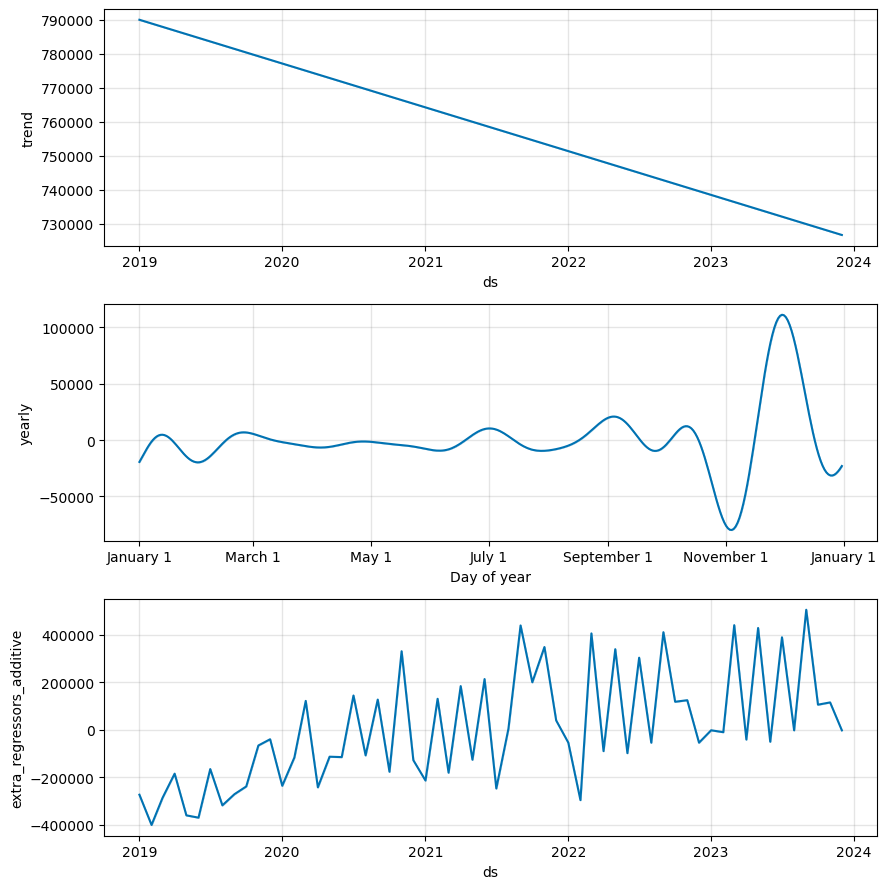

In [21]:
fig2 = model.plot_components(forecast)

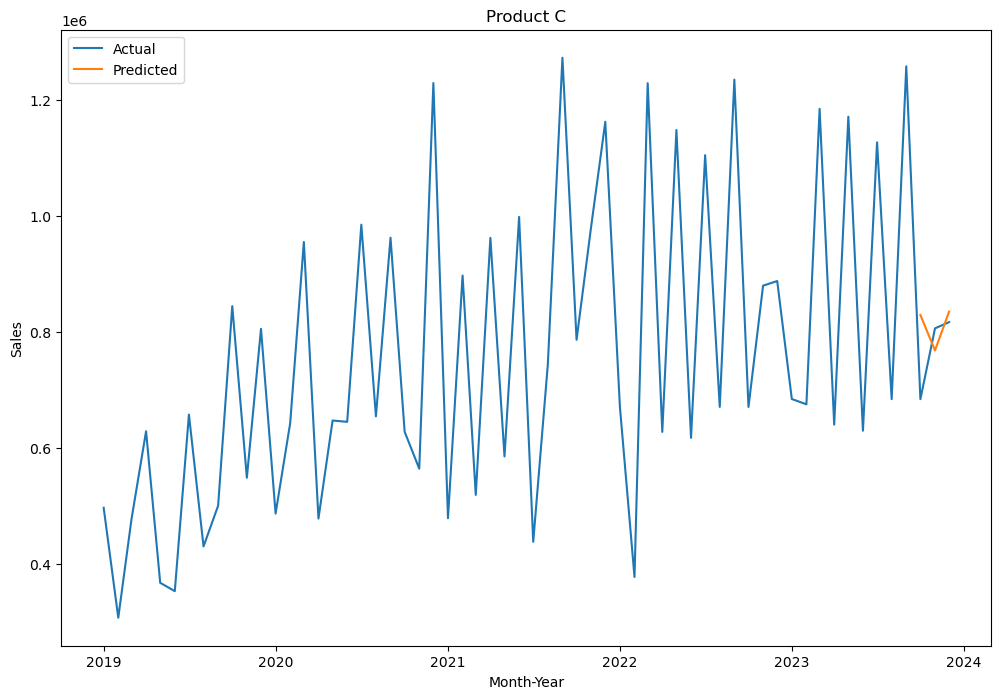

In [22]:
# Reset index of sales_b DataFrame
sales_c_reset_index = sales_c.reset_index()

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(sales_c_reset_index['ds'], sales_c_reset_index['y'], label='Actual')
plt.plot(forecasted_df['ds'], forecasted_df['yhat'], label='Predicted')
plt.title('Product C')
plt.xlabel('Month-Year')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [23]:
#model evaluation

In [24]:
pred=forecasted_df['yhat']
test_df=test['y']

In [25]:
mae_fb= mean_absolute_error(test_df,pred)
mse_fb=mean_squared_error(test_df, pred)
mape_fb= mean_absolute_percentage_error(test_df,pred)
rmse_fb= np.sqrt(mean_squared_error(test_df,pred))


print(f'MAE - FB PROPHET: {mae_fb:.3f}')
print(f'MAPE - FB PROPHET: {mape_fb:.3f}')
print(f'MSE - FB PROPHET: {mse_fb:.3f}')
print(f'RMSE - FB PROPHET: {rmse_fb:.3f}')

MAE - FB PROPHET: 67253.456
MAPE - FB PROPHET: 0.094
MSE - FB PROPHET: 7636855060.153
RMSE - FB PROPHET: 87389.101


In [26]:
#Set initial window to 2 years (24 months), period to 1 year (12 months), and horizon to 1 year (12 months)
df_cv = cross_validation(model, initial='730 days', period='90 days', horizon='90 days', parallel="processes")

In [27]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,20 days,2.770615e+10,166451.653791,146064.245810,0.251860,0.256561,0.213151,1.000000
1,22 days,1.794961e+10,133976.138699,121155.391989,0.168459,0.129118,0.153872,1.000000
2,23 days,4.942415e+09,70302.311182,67592.547656,0.095326,0.119697,0.090697,1.000000
3,25 days,2.001182e+10,141463.126321,116491.641595,0.166976,0.129118,0.148369,1.000000
4,27 days,2.035787e+10,142681.012283,121282.854937,0.181883,0.109316,0.162090,1.000000
5,28 days,3.109429e+09,55762.256776,47345.259833,0.070459,0.096972,0.067071,1.000000
6,47 days,8.043107e+09,89683.369432,71114.779058,0.115537,0.109316,0.105379,1.000000
7,49 days,8.056053e+09,89755.516252,71217.486735,0.111825,0.092008,0.102009,1.000000
8,51 days,9.238996e+09,96119.694638,89254.824968,0.130439,0.092008,0.120027,1.000000
9,52 days,4.027874e+09,63465.536980,63358.137814,0.068902,0.060930,0.067448,1.000000


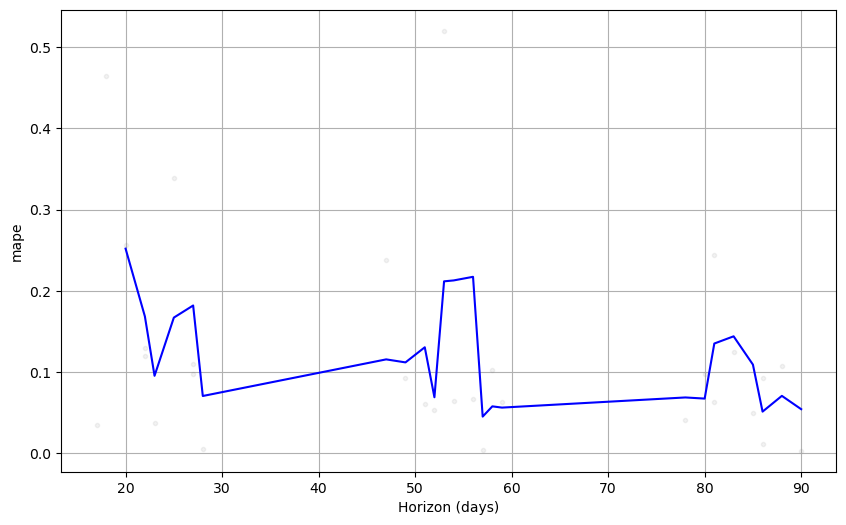

In [28]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [29]:
test_df

57    683935
58    806218
59    816978
Name: y, dtype: int64

In [30]:
pred

57    829264.592358
58    768061.319570
59    835252.093798
Name: yhat, dtype: float64